Dealing with overfitting

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
dataset_val = Subset(fmnist_dataset_test, np.random.choice(len(fmnist_dataset_test), size=int(0.2 * len(fmnist_dataset_test)), replace = False))

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_val,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)


In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
len(fmnist_dataset_train)

60000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.BatchNorm1d(input_shape * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(input_shape * 2, input_shape),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
              ReLU-4                 [-1, 1568]               0
           Dropout-5                 [-1, 1568]               0
            Linear-6                  [-1, 784]       1,230,096
           Dropout-7                  [-1, 784]               0
              ReLU-8                  [-1, 784]               0
            Linear-9                   [-1, 10]           7,850
       LogSoftmax-10                   [-1, 10]               0
Total params: 2,471,962
Trainable params: 2,471,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 9.43
Estimat

In [ ]:
model = TinyNeuralNetwork().to(device)
lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr)
loss_func = nn.NLLLoss()
n_epoch = 20

# Your experiments, training and validation loops here

In [ ]:
from sklearn.metrics import accuracy_score
from IPython import display

In [ ]:
def train(model, X, X_val, loss_func, optim, n_epoch):
  train_loss = []
  val_loss = []
  val_accuracy = []
  for i in range(n_epoch):
    model.train(True)
    epoch_train_loss = []
    epoch_val_loss = []
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optim.zero_grad()
      predictions = model(X_batch)
      loss = loss_func(predictions, y_batch)
      loss.backward()
      optim.step()
      epoch_train_loss.append(loss.item())
    model.train(False)
    epoch_val_accuracy = []
    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        loss = loss_func(predictions, y_batch)
        predictions = predictions.max(dim=1)[1]
        epoch_val_accuracy.append(accuracy_score(predictions.cpu().numpy(), y_batch.cpu().numpy()))
        epoch_val_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    val_accuracy.append(np.mean(epoch_val_accuracy))
    val_loss.append(np.mean(epoch_val_loss))

    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss, 'b', label='train loss')
    plt.plot(val_loss, 'r', label='val loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(val_accuracy, 'b')
    plt.show()

    print('Current loss: %f' % loss)

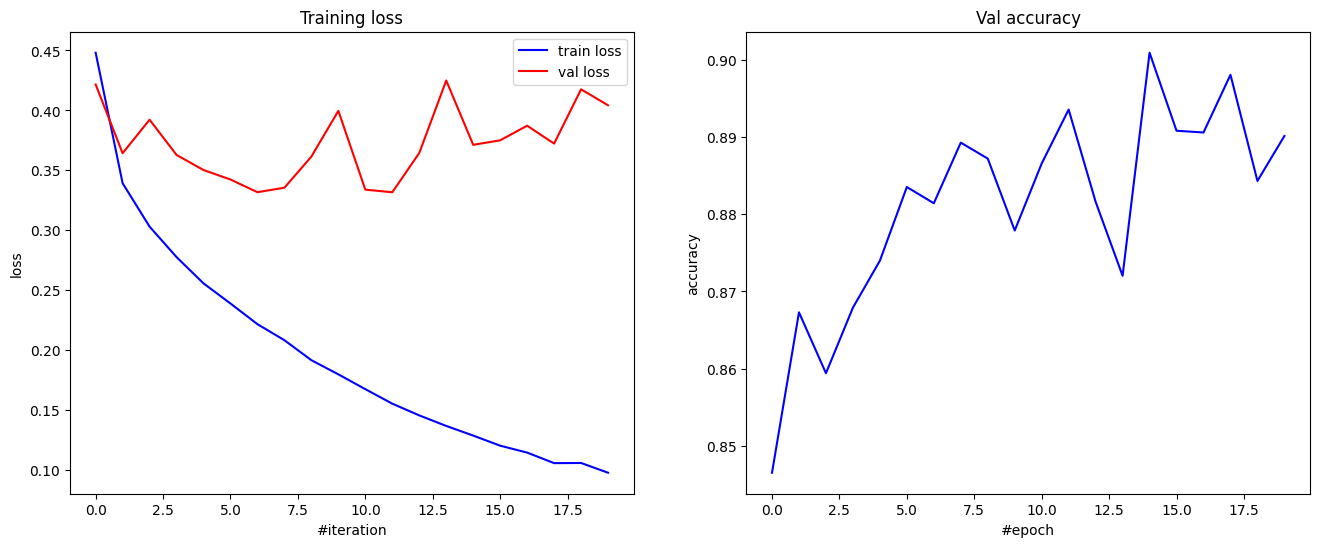

Current loss: 0.469400


In [ ]:
train(model, train_loader, val_loader, loss_func, opt, n_epoch)

In [ ]:
model.train(False)
accuracy = []
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    predictions = model(X_batch)
    predictions = predictions.max(dim=1)[1]
    accuracy.append(accuracy_score(predictions.cpu().numpy(), y_batch.cpu().numpy()))
print(np.mean(accuracy))

0.89541015625


### Overfitting the model.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 784]       1,230,096
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 2,468,826
Trainable params: 2,468,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 9.42
Estimated Total Size (MB): 9.46
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
lr = 0.0001
opt = torch.optim.Adam(model.parameters(), lr)
loss_func = nn.NLLLoss()
n_epoch = 30

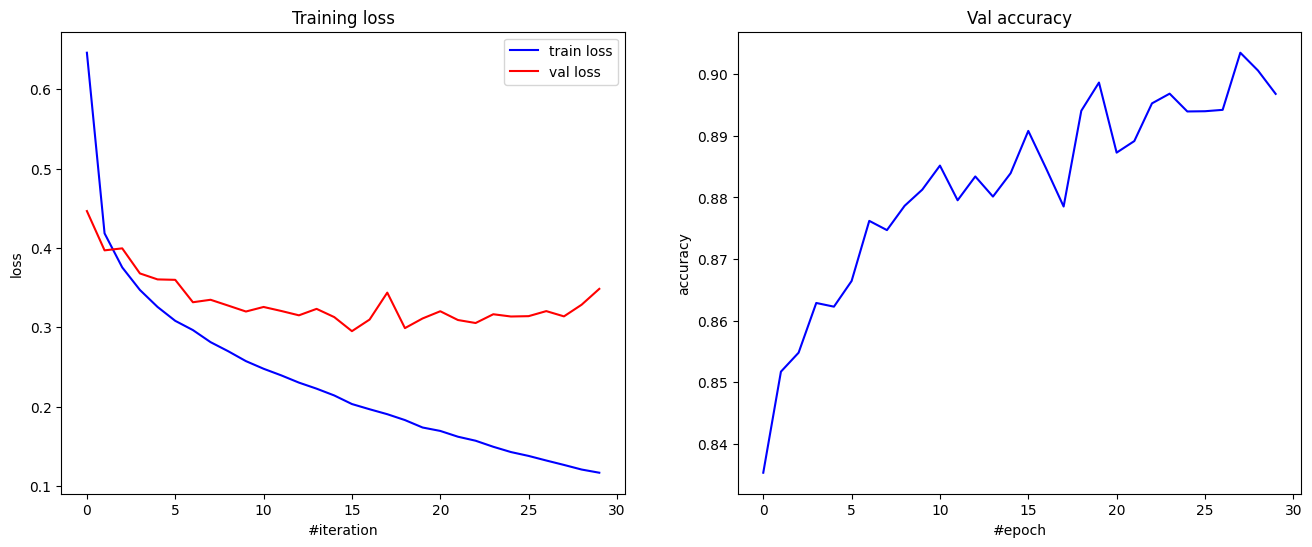

Current loss: 0.318337


In [ ]:
train(model, train_loader, val_loader, loss_func, opt, n_epoch)

In [ ]:
model.train(False)
accuracy = []
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    predictions = model(X_batch)
    predictions = predictions.max(dim=1)[1]
    accuracy.append(accuracy_score(predictions.cpu().numpy(), y_batch.cpu().numpy()))
print(np.mean(accuracy))

0.8970703125


### Fixing the overfitted network

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
              ReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 256]         131,328
           Dropout-7                  [-1, 256]               0
              ReLU-8                  [-1, 256]               0
       BatchNorm1d-9                  [-1, 256]             512
           Linear-10                  [-1, 128]          32,896
          Dropout-11                  [-1, 128]               0
             ReLU-12                  [-1, 128]               0
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

In [ ]:
model = FixedNeuralNetwork().to(device)
lr = 0.0001
opt = torch.optim.Adam(model.parameters(), lr)
loss_func = nn.NLLLoss()
n_epoch = 50

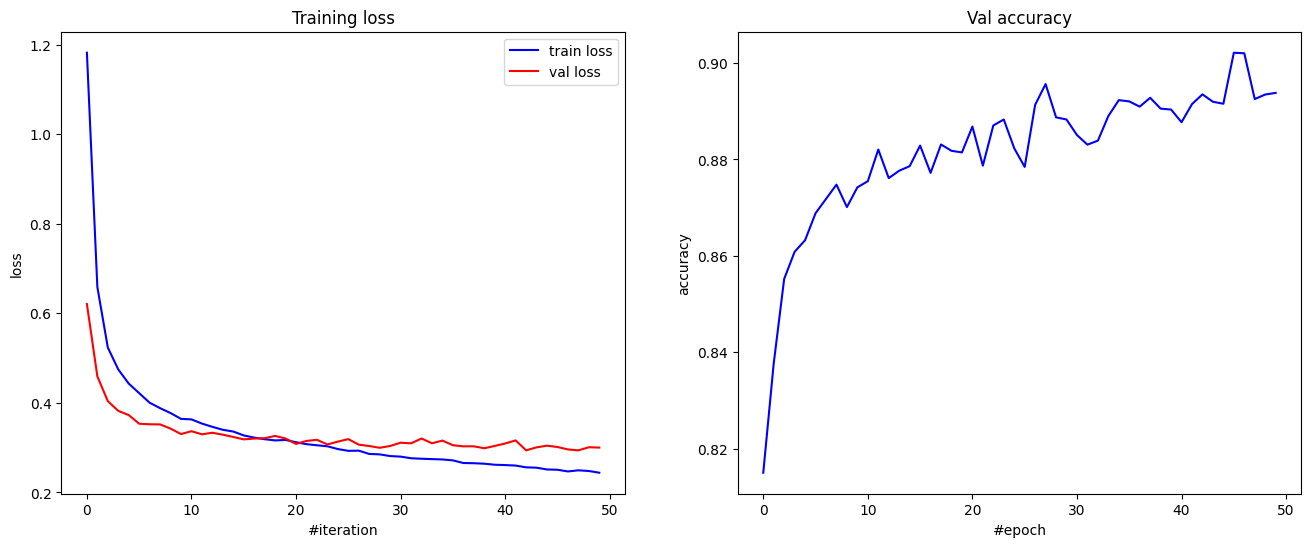

Current loss: 0.239675


In [ ]:
train(model, train_loader, val_loader, loss_func, opt, n_epoch)

In [ ]:
model.train(False)
accuracy = []
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    predictions = model(X_batch)
    predictions = predictions.max(dim=1)[1]
    accuracy.append(accuracy_score(predictions.cpu().numpy(), y_batch.cpu().numpy()))
print(np.mean(accuracy))

0.8904296875
